In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasetlowestaicspatiallocal/dataset_lowestAIC_longlat-Local.csv


In [2]:
#import dataset 
df = pd.read_csv(r'../input/datasetlowestaicspatiallocal/dataset_lowestAIC_longlat-Local.csv', sep=';')

## Data processing

In [3]:
#remove geodata
df = df.drop(['Longitude', 'Latitude', 'Unnamed: 0'], axis=1)

In [4]:
df.head()

,Lopend_gemiddelde,nightlight_900,road_class_2_5000,trafBuf50
0,28.1,45.651295,70853.39844,0.000000
1,56.2,27.055981,59697.10938,3976.155390
2,39.1,34.337959,59120.18359,1637.333333
3,42.9,42.282043,59951.94922,1637.333333
4,27.0,39.803818,54304.76953,0.000000


In [5]:
#remove NAs and replace with 0
df=df.fillna(0)

In [6]:
y = df['Lopend_gemiddelde']
x = df.drop(['Lopend_gemiddelde'], axis=1)
feature_list = list(x.columns)

In [7]:
print(x)

     nightlight_900  road_class_2_5000    trafBuf50
0         45.651295        70853.39844     0.000000
1         27.055981        59697.10938  3976.155390
2         34.337959        59120.18359  1637.333333
3         42.282043        59951.94922  1637.333333
4         39.803818        54304.76953     0.000000
..              ...                ...          ...
127       24.581779        58010.05078  1626.500000
128       21.490236        51133.18750     0.000000
129       17.125080        43750.90234     0.000000
130       38.193729        59573.08203     0.000000
131       14.957702        46578.17969     0.000000

[132 rows x 3 columns]


In [8]:
                         ## Import the (modules of) models we are using
        
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
import lightgbm as lgb


In [9]:
#models

#Non-linear

#Random Forest
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, min_samples_split=10,
                          min_samples_leaf=5,max_features=1,max_depth=10, bootstrap=True )

#LightGBM
lightgbm_model = lgb.LGBMRegressor(reg_alpha =2, reg_lambda = 0, max_depth = 5, learning_rate = 0.0005, n_estimators =50000, random_state=42)
#XGBoost
xgb= xgb.XGBRegressor(gamma = 5,  reg_alpha =2, reg_lambda=0, max_depth = 5, learning_rate = 0.0005, n_estimators=50000, random_state=42)


#linear models

#Lasso
model_lasso = Lasso(alpha=0.1)
#Ridge
ridge2 = Ridge(alpha = 0.3, normalize = True)


In [10]:
#random states - CV = 20
random_states = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95] #random state is needed to ensure that same results are generated each time.
#models
models = [rf, lightgbm_model, xgb, model_lasso, ridge2]
#model_names
model_names = ['rf', 'lgb', 'xgb', 'lasso', 'ridge']

In [11]:
print(models)

[RandomForestRegressor(max_depth=10, max_features=1, min_samples_leaf=5,
                      min_samples_split=10, n_estimators=1000, random_state=42), LGBMRegressor(learning_rate=0.0005, max_depth=5, n_estimators=50000,
              random_state=42, reg_alpha=2, reg_lambda=0), XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=5, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0005, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=50000, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=42,
             reg_alpha=2, reg_lambda=0, ...

In [12]:
#construct cross-validation via loop


#create dictionaries that eventually stores performance per model (CV)
total_rmse = {}
total_r2 = {}
total_mae = {}

rmse_vals_round = []
#start with first model
for i,k in zip(models,model_names):
    #initialize lists where performances can be stored to
    locals()[str(k)+"RMSE_scores"] = []
    locals()[str(k)+"R2_scores"] = []
    locals()[str(k)+"MAE_scores"] = []
    print(" ")
    print("next model:", str(k))
    print(" ")
#     for j in range(0, len(random_states)):
    for j in random_states:    
        #split dataset into training- and testing dataset
        X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25, random_state=j)
        print(j)
        #train the model
        i.fit(X_train, Y_train)
#         print(X_train)
        
        #predict based on the training data
        preds_test = i.predict(X_test)
       
    
        ##RMSE
        #create function that calculates RMSE
        def rmse(predictions, targets):
            return np.sqrt(((predictions - targets) ** 2).mean())

        print('RMSE testing: ', rmse(preds_test, Y_test))
        rmse_val = rmse(preds_test, Y_test)
        #store result to list
        locals()[str(k)+"RMSE_scores"].append(rmse_val)
        
    
        ##R2
        print('R2 score testing: ', r2_score(Y_test, preds_test))
        r2_val = r2_score(Y_test, preds_test)
        #store result to list
        locals()[str(k)+"R2_scores"].append(r2_val)
    
        ##MEAN ABSOLUTE ERROR 
        print('MAE testing: ', mean_absolute_error(Y_test, preds_test))
        mae_val = mean_absolute_error(Y_test, preds_test)
        #store result to list
        locals()[str(k)+"MAE_scores"].append(mae_val)

    #store to dictionary
    total_rmse[k] = locals()[str(k)+"RMSE_scores"]
    total_r2[k] = locals()[str(k)+"R2_scores"]
    total_mae[k] = locals()[str(k)+"MAE_scores"]


 
next model: rf
 
1
RMSE testing:  7.009621026727553
R2 score testing:  0.274781870179988
MAE testing:  5.723335905311475
5
RMSE testing:  7.058294000077562
R2 score testing:  0.4682123863387093
MAE testing:  5.816680461095763
10
RMSE testing:  8.319012308035031
R2 score testing:  0.2608662797886582
MAE testing:  6.868689639635956
15
RMSE testing:  7.641535090954618
R2 score testing:  0.06150439675963615
MAE testing:  6.18272764849354
20
RMSE testing:  8.551301575389607
R2 score testing:  0.13089988789719842
MAE testing:  6.521736380879495
25
RMSE testing:  8.007164974737334
R2 score testing:  0.36060265560162297
MAE testing:  6.323667064151996
30
RMSE testing:  7.263169507867874
R2 score testing:  0.3298587330682152
MAE testing:  5.846562351803443
35
RMSE testing:  7.658953251766764
R2 score testing:  0.1560118291295287
MAE testing:  6.461433664693423
40
RMSE testing:  7.9475492457692525
R2 score testing:  -0.36680887446253574
MAE testing:  6.734573785400691
45
RMSE testing:  6.87877

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipel

In [13]:
#examine
print(total_rmse)
print(total_r2)
print(total_mae)

{'rf': [7.009621026727553, 7.058294000077562, 8.319012308035031, 7.641535090954618, 8.551301575389607, 8.007164974737334, 7.263169507867874, 7.658953251766764, 7.9475492457692525, 6.878774000505655, 7.956366069617706, 7.197057147904982, 7.356427255331858, 7.056801343769754, 6.693508867843403, 6.273890397754928, 7.694509169926342, 7.93500888585698, 8.37861308761304, 7.720804967281112], 'lgb': [7.230268923492837, 6.5375788881964185, 7.536101990998662, 7.202280337039494, 8.917593941557898, 7.174692861255573, 7.349216754629356, 7.638332348131815, 7.766492647509777, 7.04166709507463, 7.658593063020341, 7.180853532743592, 7.07547521409556, 7.739775014342955, 6.720107060683908, 6.14304131322848, 8.494902302194932, 7.905595364888146, 8.660004385044523, 8.144848393561993], 'xgb': [9.291412502186354, 7.067176923327731, 10.12132579970538, 8.908378866487347, 9.318382897837331, 9.016914960802469, 7.438987078910822, 7.857524310411141, 9.226222767963183, 8.094596937658157, 9.035554806557005, 7.996497

In [14]:
#convert to pandas dataframes
df_total_rmse = pd.DataFrame(total_rmse)
df_total_r2 = pd.DataFrame(total_r2)
df_total_mae = pd.DataFrame(total_mae)

In [15]:
#examine
df_total_rmse.head(10)

,rf,lgb,xgb,lasso,ridge
0,7.009621,7.230269,9.291413,6.791630,6.815737
1,7.058294,6.537579,7.067177,7.440889,7.641684
2,8.319012,7.536102,10.121326,7.592337,7.777913
3,7.641535,7.202280,8.908379,8.205279,7.821713
4,8.551302,8.917594,9.318383,7.640791,7.795583
5,8.007165,7.174693,9.016915,7.600500,7.844158
6,7.263170,7.349217,7.438987,6.989707,7.104180
7,7.658953,7.638332,7.857524,7.617708,7.482661
8,7.947549,7.766493,9.226223,8.369282,7.943149
9,6.878774,7.041667,8.094597,6.896234,6.948830


In [16]:
#examine cross-validation root mean square error per model
df_total_rmse.describe()

,rf,lgb,xgb,lasso,ridge
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,7.529918,7.505871,8.583574,7.454478,7.448825
std,0.600752,0.697993,1.011840,0.557152,0.493001
min,6.273890,6.143041,6.739889,6.505913,6.455639
25%,7.057921,7.149888,7.831014,6.968749,6.998487
50%,7.650244,7.442659,8.674975,7.596419,7.562172
75%,7.949753,7.801268,9.298155,7.832409,7.827324
max,8.551302,8.917594,10.344410,8.369282,8.146663


In [17]:
#examine
df_total_r2.head()

,rf,lgb,xgb,lasso,ridge
0,0.274782,0.228407,-0.274216,0.319187,0.314346
1,0.468212,0.543782,0.466873,0.408999,0.376672
2,0.260866,0.393441,-0.094093,0.384355,0.353891
3,0.061504,0.166298,-0.275465,-0.082076,0.016725
4,0.130900,0.054850,-0.032016,0.306124,0.277725


In [18]:
#examine cross-validation r2 per model
df_total_r2.describe()

,rf,lgb,xgb,lasso,ridge
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.233156,0.233011,-0.003926,0.240132,0.249456
std,0.184924,0.206153,0.297500,0.228615,0.180055
min,-0.366809,-0.305242,-0.841998,-0.515716,-0.365296
25%,0.150437,0.145609,-0.164786,0.161574,0.186847
50%,0.256587,0.268622,0.062313,0.312656,0.299368
75%,0.354351,0.393979,0.195413,0.389526,0.362822
max,0.468212,0.543782,0.466873,0.440997,0.423185


In [19]:
#examine cross-validation mean absolute error per model
df_total_mae.describe()

,rf,lgb,xgb,lasso,ridge
count,20.000000,20.000000,20.000000,20.000000,20.000000
mean,6.114606,6.094156,6.643600,5.979765,5.995280
std,0.541751,0.546895,0.856209,0.522903,0.463143
min,5.078870,5.103390,5.195891,5.183956,5.105100
25%,5.793344,5.772637,6.067599,5.592442,5.650743
50%,6.217969,6.046828,6.507031,5.892161,6.002760
75%,6.471352,6.448671,7.136852,6.325156,6.214910
max,7.124223,7.191865,8.431466,7.145480,6.779784


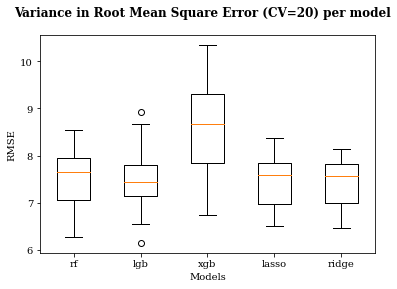

In [20]:
import matplotlib.pyplot as plt

#define font
plt.rcParams["font.family"] = "serif"

fig = plt.figure()

fig.suptitle('Variance in Root Mean Square Error (CV=20) per model', fontsize=12, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(df_total_rmse)

ax.set_xticks([1, 2, 3, 4, 5], ['rf', 'lgb', 'xgb', 'lasso', 'ridge'])

ax.set_xlabel('Models')
ax.set_ylabel('RMSE')

plt.savefig('RMSE - CV20 - ModelPerformances', bbox_inches='tight',
           facecolor=(1, 1, 1))
plt.show()


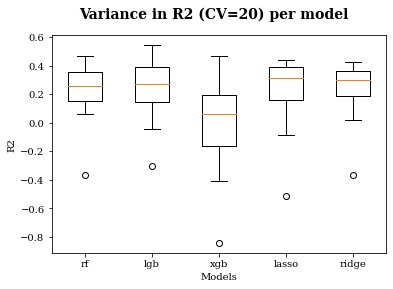

In [21]:
#define font
plt.rcParams["font.family"] = "serif"

fig = plt.figure()
fig.suptitle('Variance in R2 (CV=20) per model', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(df_total_r2)

ax.set_xticks([1, 2, 3, 4, 5], ['rf', 'lgb', 'xgb', 'lasso', 'ridge'])

ax.set_xlabel('Models')
ax.set_ylabel('R2')

plt.savefig('R2 - CV20 - ModelPerformances', bbox_inches='tight',
           facecolor=(1, 1, 1))

plt.show()

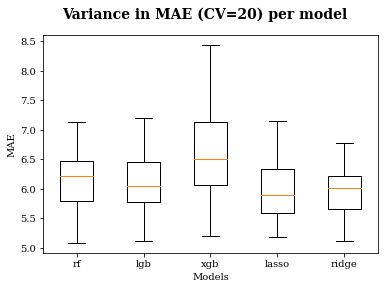

In [22]:
#define font
plt.rcParams["font.family"] = "serif"

fig = plt.figure()
fig.suptitle('Variance in MAE (CV=20) per model', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(df_total_mae)

ax.set_xticks([1, 2, 3, 4, 5], ['rf', 'lgb', 'xgb', 'lasso', 'ridge'])

ax.set_xlabel('Models')
ax.set_ylabel('MAE')

plt.savefig('MAE - CV20 - ModelPerformances', bbox_inches='tight',
           facecolor=(1, 1, 1))

plt.show()